# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import CountVectorizer

## Data loading



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [4]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(24, '1t'), (24, '1t'), (551, 'likely'), (237, 'college'), (940, 'users'), (699, 'police'), (436, 'great'), (517, 'just'), (948, 'values'), (814, 'serial')]


In [5]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


In [6]:
# get only 1000 documents
data = np.array(newsgroups_train.data[:1000])
classes = np.array(newsgroups_train.target[:1000])

# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [7]:
import collections
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))

Nb mots= 277664


### Plot the N frequent words and verify that its follows a Zipf law

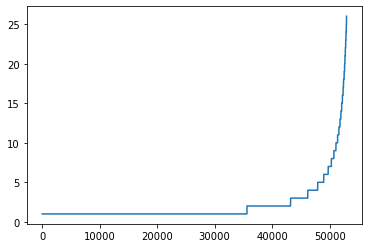

In [8]:
words = np.array(words)
keys,values = np.unique(words,return_counts=True)
freq_ind = np.argsort(values)[:-1000]
plt.plot(values[freq_ind])

### Experiment word clouds

(-0.5, 399.5, 199.5, -0.5)

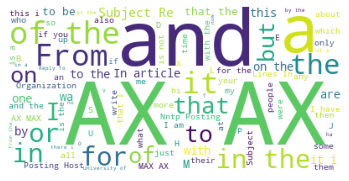

In [9]:
wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

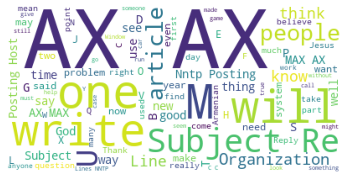

In [10]:
from wordcloud import STOPWORDS # Note: this is the default option           
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data)
X = vectors.toarray()

In [17]:
frequencies = {}
for i in range(X.shape[1]):
    frequencies[vectorizer.get_feature_names()[i]] = np.sum(X[:,i])

/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(-0.5, 399.5, 199.5, -0.5)

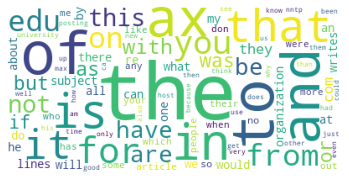

In [18]:
wordcloud = WordCloud(background_color='white',stopwords = STOPWORDS, max_words=100).generate_from_frequencies(frequencies) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Drawing word clouds from classes


In [19]:
def get_freq_word(X,vectorizer):
    words = []
    for i in range(X.shape[1]):
        words.append(np.sum(X[:,i]))
    return vectorizer.get_feature_names()[np.argmax(words)]
    

def get_corpus_classes(values,classes):
    corpus_classes = []
    for classe in values:
        data_classe = data[np.where(classes == classe)]
        corpus_classes.append("".join(data_classe))
    return corpus_classes

def get_data_clusters(values,labels):
    corpus_clusters = []
    for classe in values:
        data_classe = data[np.where(labels == classe)]
        corpus_clusters.append(data_classe)
    return corpus_clusters

values_classes = np.unique(classes)
corpus_classes = get_corpus_classes(values_classes,classes)

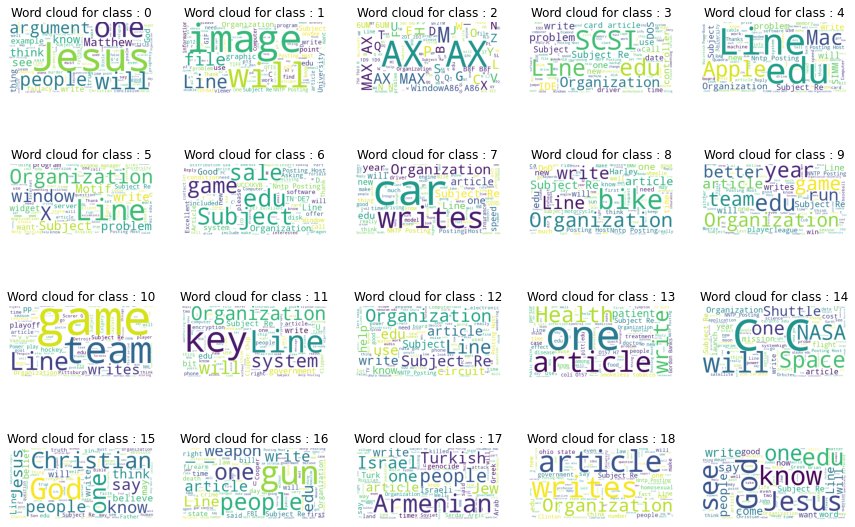

In [20]:
plt.figure(figsize=(15,10))
for i_classe in values_classes:
    cc = corpus_classes[i_classe]
    wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(cc)            
    plt.title("Word cloud for class : "+str(i_classe-1))
    plt.subplot(4, 5,i_classe+1)
    plt.imshow(wordcloud)
    plt.axis('off')
plt.show()

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [21]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
print(kmeans.cluster_centers_.shape)
print(np.unique(kmeans.labels_,return_counts=True))
print(kmeans.labels_.shape)

(20, 32190)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32), array([  1,   1,   1,   1,   7, 319,   3,   3, 455,   1,   1, 122,   1,
        62,   7,   1,   1,  11,   1,   1]))
(1000,)


### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= \frac{|y^*|}{|C_j|}$, where $y^*$ is the most frequent (GT) label in cluster $C$ $\Rightarrow$ $p = \sum\limits_j |C_j| p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

## Qualitative

### Important word for each cluster

- Via le centroid du cluster

In [22]:
print("Les mots les plus importants : ")
centroids = kmeans.cluster_centers_
for i_centroid in range(len(centroids)):
    print("Pour le cluster ",i_centroid," est : ",vectorizer.get_feature_names()[np.argmax(centroids[i_centroid])])

Les mots les plus importants : 
Pour le cluster  0  est :  den
Pour le cluster  1  est :  ax
Pour le cluster  2  est :  the
Pour le cluster  3  est :  the
Pour le cluster  4  est :  the
Pour le cluster  5  est :  the
Pour le cluster  6  est :  the
Pour le cluster  7  est :  the
Pour le cluster  8  est :  the
Pour le cluster  9  est :  the
Pour le cluster  10  est :  the
Pour le cluster  11  est :  the


/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Pour le cluster  12  est :  and
Pour le cluster  13  est :  the
Pour le cluster  14  est :  the
Pour le cluster  15  est :  m0
Pour le cluster  16  est :  the
Pour le cluster  17  est :  the
Pour le cluster  18  est :  of
Pour le cluster  19  est :  the


- via tous le cluster

In [23]:
labels = kmeans.labels_
values_labels = np.unique(labels)
data_clusters = get_data_clusters(values_labels,labels)

for i_data_c in range(len(data_clusters)):
    vecto = CountVectorizer()
    X = vecto.fit_transform(data_clusters[i_data_c])
    word = get_freq_word(X,vecto)
    print("Pour le cluster ",i_data_c," est : ",word)

Pour le cluster  0  est :  den
Pour le cluster  1  est :  ax
Pour le cluster  2  est :  the
Pour le cluster  3  est :  the
Pour le cluster  4  est :  the
Pour le cluster  5  est :  the
Pour le cluster  6  est :  the
Pour le cluster  7  est :  the
Pour le cluster  8  est :  the
Pour le cluster  9  est :  the
Pour le cluster  10  est :  the
Pour le cluster  11  est :  the
Pour le cluster  12  est :  and
Pour le cluster  13  est :  the
Pour le cluster  14  est :  the
Pour le cluster  15  est :  m0
Pour le cluster  16  est :  the
Pour le cluster  17  est :  the
Pour le cluster  18  est :  of
Pour le cluster  19  est :  the


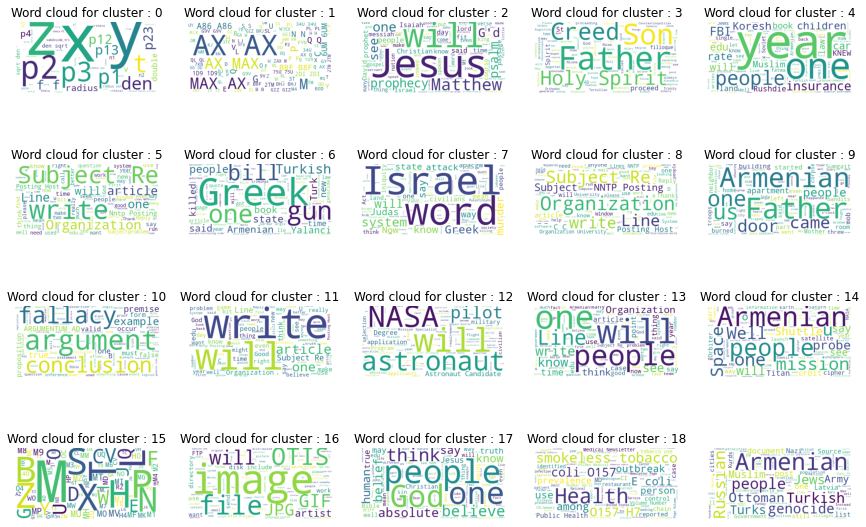

In [24]:
corpus_clusters = get_corpus_classes(values_labels,labels)

plt.figure(figsize=(15,10))
for i_classe in values_labels:
    cc = corpus_clusters[i_classe]
    wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(cc)            
    plt.title("Word cloud for cluster : "+str(i_classe-1))
    plt.subplot(4, 5,i_classe+1)
    plt.imshow(wordcloud)
    plt.axis('off')
plt.show()

## Quantitative

### Purity

In [25]:
def get_classe_cluster(cluster):
    shape0 = len(cluster)
    cluster_data = np.array(cluster).reshape((shape0,1))
    return classes[np.where(data == cluster_data)[1]]

def get_perity_cluster(classes_cluster):
    cla,vals = np.unique(classes_cluster,return_counts=True)
    return np.max(vals) / len(classes_cluster)

In [26]:
for i_cluster in range(len(data_clusters)):
    classes_cluster = get_classe_cluster(data_clusters[i_cluster])
    print("Purete du cluster ",i_cluster,"est ",get_perity_cluster(classes_cluster))

Purete du cluster  0 est  1.0
Purete du cluster  1 est  1.0
Purete du cluster  2 est  1.0
Purete du cluster  3 est  1.0
Purete du cluster  4 est  0.42857142857142855
Purete du cluster  5 est  0.0877742946708464
Purete du cluster  6 est  0.6666666666666666
Purete du cluster  7 est  0.3333333333333333
Purete du cluster  8 est  0.0967032967032967
Purete du cluster  9 est  1.0
Purete du cluster  10 est  1.0
Purete du cluster  11 est  0.14754098360655737
Purete du cluster  12 est  1.0
Purete du cluster  13 est  0.11290322580645161
Purete du cluster  14 est  0.2857142857142857
Purete du cluster  15 est  1.0
Purete du cluster  16 est  1.0
Purete du cluster  17 est  0.7272727272727273
Purete du cluster  18 est  1.0
Purete du cluster  19 est  1.0


### Rand Score

In [27]:
from sklearn.metrics import rand_score,adjusted_rand_score
print("Rand score  : ",rand_score(classes,labels))
print("Adjusted Rand Score : ",adjusted_rand_score(classes,labels))

Rand score  :  0.6602622622622623
Adjusted Rand Score :  0.013807706782600349


# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [28]:
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data)
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
U = svd.fit_transform(vectors)
V = svd.components_

In [29]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=0)
tsne_mat = tsne.fit_transform(U)

/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


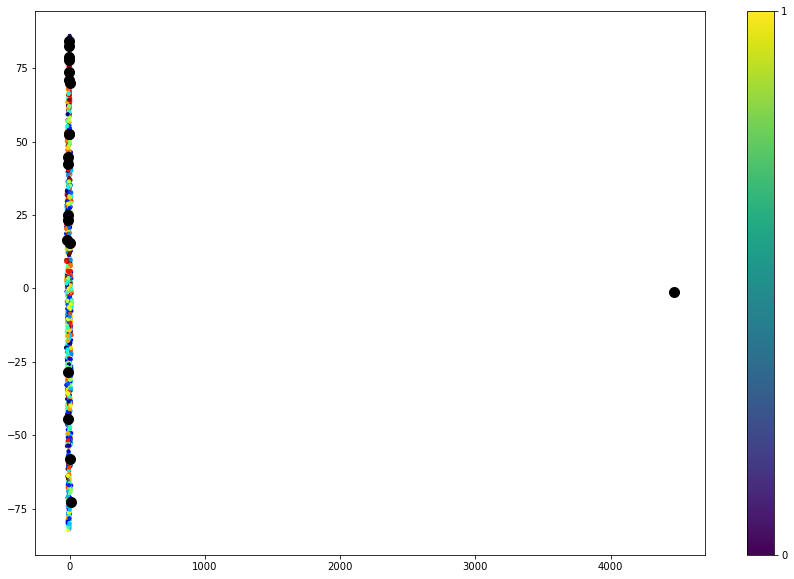

In [46]:
NN2cluster = np.argmax(np.abs(U), axis=0)
#import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20
Y = newsgroups_train.target[:1000]
plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1],c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1],c='black', s=100)
# plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

In [31]:

def labelize_documents(U):
    return np.argmax(np.abs(U),axis=1)
# Associer au document le label 'i' quand : 'i' est le label du mots le plus frequent du document 
# def labelize_documents(vectors,labels_vocabulary):
#     X = vectors.toarray()
#     labels_lsa = []
#     for i in range(X.shape[0]):
#         cla,vals = np.unique(labels_vocabulary[np.where(X[i] != 0)],return_counts=True)
#         labels_lsa.append(cla[np.argmax(vals)])
#     return np.array(labels_lsa)
labels_lsa = labelize_documents(U)

values_labels_lsa = np.unique(labels_lsa)
data_clusters_lsa = get_data_clusters(values_labels_lsa,labels_lsa)

for i_cluster in range(len(data_clusters_lsa)):
    classes_cluster = get_classe_cluster(data_clusters_lsa[i_cluster])
    print("Purete du cluster ",i_cluster,"est ",get_perity_cluster(classes_cluster))
    
print("Rand score  : ",rand_score(classes,labels_lsa))
print("Adjusted Rand Score : ",adjusted_rand_score(classes,labels_lsa))

Purete du cluster  0 est  1.0
Purete du cluster  1 est  0.07104413347685684
Purete du cluster  2 est  1.0
Purete du cluster  3 est  0.3142857142857143
Purete du cluster  4 est  1.0
Purete du cluster  5 est  1.0
Purete du cluster  6 est  1.0
Purete du cluster  7 est  1.0
Purete du cluster  8 est  1.0
Purete du cluster  9 est  0.20833333333333334
Purete du cluster  10 est  0.8
Rand score  :  0.17226226226226227
Adjusted Rand Score :  0.00034559218917739855


# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [35]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# # Initialize regex tokenizer
# tokenizer = RegexpTokenizer(r'\w+')

# # Vectorize document using TF-IDF
# vectorizer = CountVectorizer(lowercase=True,
#                         stop_words='english',
#                         ngram_range = (1,1),
#                         tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))

lda = LatentDirichletAllocation(n_components=20,random_state=42)
U = lda.fit_transform(vectors)

(1000, 32190)
157.775


In [36]:

labels_lda = labelize_documents(U)

values_labels_lda = np.unique(labels_lda)
data_clusters_lda = get_data_clusters(values_labels_lda,labels_lda)

for i_cluster in range(len(data_clusters_lda)):
    classes_cluster = get_classe_cluster(data_clusters_lda[i_cluster])
    print("Purete du cluster ",i_cluster,"est ",get_perity_cluster(classes_cluster))
    
print()
print("Rand score  : ",rand_score(classes,labels_lda))
print("Adjusted Rand Score : ",adjusted_rand_score(classes,labels_lda))

Purete du cluster  0 est  0.2631578947368421
Purete du cluster  1 est  1.0
Purete du cluster  2 est  0.14285714285714285
Purete du cluster  3 est  0.11724137931034483
Purete du cluster  4 est  0.42857142857142855
Purete du cluster  5 est  0.5
Purete du cluster  6 est  0.2857142857142857
Purete du cluster  7 est  0.2
Purete du cluster  8 est  0.5
Purete du cluster  9 est  0.24545454545454545
Purete du cluster  10 est  0.1377551020408163
Purete du cluster  11 est  0.16666666666666666
Purete du cluster  12 est  0.5
Purete du cluster  13 est  0.21428571428571427
Purete du cluster  14 est  0.5
Purete du cluster  15 est  0.1320754716981132
Purete du cluster  16 est  0.25
Purete du cluster  17 est  0.09433962264150944
Purete du cluster  18 est  0.4
Purete du cluster  19 est  0.3333333333333333

Rand score  :  0.8128428428428428
Adjusted Rand Score :  0.033350358387443504


## LDA-viz

In [38]:
# !pip install install pyldavis
from __future__ import print_function

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


pyLDAvis.sklearn.prepare(lda,vectors,vectorizer)

/home/amine/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/amine/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.261700  0.008583       1        1  22.816903
9     -0.255073  0.024854       2        1  21.914387
10    -0.302363  0.041421       3        1  21.838481
3     -0.241897  0.010964       4        1   8.119341
2     -0.230670  0.006426       5        1   7.135178
14     0.175431  0.392098       6        1   4.375888
15    -0.169694  0.004956       7        1   3.019010
8      0.219095 -0.001690       8        1   2.720441
12     0.114954 -0.031459       9        1   1.110029
13     0.023141 -0.039729      10        1   1.002193
7      0.051128 -0.044557      11        1   0.912620
0      0.018467 -0.042093      12        1   0.855807
18     0.140280 -0.035901      13        1   0.824708
16     0.024748 -0.047933      14        1   0.749881
4      0.050963 -0.030426      15        1   0.736795
19     0.093057 -0.050557      16        1   0.605211
6      0.102132 -0.047336      17        1   0.473554
11     0.132176 -0.043270      18        1   0.405244
5      0.151529 -0.039773      19        1   0.326750
1      0.164295 -0.034579      20        1   0.057578, topic_info=              Term          Freq         Total Category  logprob  loglift
6401            ax   4381.000000   4381.000000  Default  30.0000  30.0000
11922          edu   1569.000000   1569.000000  Default  29.0000  29.0000
28534          the  12270.000000  12270.000000  Default  28.0000  28.0000
21673           of   6032.000000   6032.000000  Default  27.0000  27.0000
16187           in   4076.000000   4076.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
7328         books      0.101271     14.044689  Topic20  -7.4071   2.5276
28061     symantec      0.101271      3.058707  Topic20  -7.4071   4.0518
562            125      0.101271      6.199437  Topic20  -7.4071   3.3454
31211  wordperfect      0.101271      2.230274  Topic20  -7.4071   4.3677
19093     magnusug      0.101271      3.559847  Topic20  -7.4071   3.9001

[1344 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          1  0.116959       00
0          2  0.116959       00
0          3  0.038986       00
0          5  0.116959       00
0          7  0.068226       00
...      ...       ...      ...
32125     17  0.653542  zoology
32135      6  0.121362       zq
32135      8  0.849533       zq
32159      2  0.956370     zuma
32159     17  0.039849     zuma

[3171 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 10, 11, 4, 3, 15, 16, 9, 13, 14, 8, 1, 19, 17, 5, 20, 7, 12, 6, 2])

# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**

- Pour pouvoir comparer les trois approches d'une maniere equitable nous allons tous les vectorizer avec le meme objet vectorizer ( les memes parametres )

In [39]:
tokenizer = RegexpTokenizer(r'\w+')
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(data)
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
labels = kmeans.labels_
values_labels = np.unique(labels)
data_clusters = get_data_clusters(values_labels,labels)
perities = []
for i_cluster in range(len(data_clusters)):
    classes_cluster = get_classe_cluster(data_clusters[i_cluster])
    perities.append(get_perity_cluster(classes_cluster))
    
purity_kmean = np.mean(perities)
rs_kmean = rand_score(classes,labels)
ars_kmean = adjusted_rand_score(classes,labels)

In [41]:
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(data)
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
U = svd.fit_transform(vectors)

labels_lsa = labelize_documents(U)

values_labels_lsa = np.unique(labels_lsa)
data_clusters_lsa = get_data_clusters(values_labels_lsa,labels_lsa)
purities = []
for i_cluster in range(len(data_clusters_lsa)):
    classes_cluster = get_classe_cluster(data_clusters_lsa[i_cluster])
    purities.append(get_perity_cluster(classes_cluster))
    
purity_lsa = np.mean(perities)
rs_lsa = rand_score(classes,labels_lsa)
ars_lsa = adjusted_rand_score(classes,labels_lsa)

In [42]:
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(data)
lda = LatentDirichletAllocation(n_components=20,random_state=42)
U = lda.fit_transform(vectors)



labels_lda = labelize_documents(U)

values_labels_lda = np.unique(labels_lda)
data_clusters_lda = get_data_clusters(values_labels_lda,labels_lda)
purities = []
for i_cluster in range(len(data_clusters_lda)):
    classes_cluster = get_classe_cluster(data_clusters_lda[i_cluster])
    purities.append(get_perity_cluster(classes_cluster))
    
purity_lda = np.mean(perities)
rs_lda = rand_score(classes,labels_lda)
ars_lda = adjusted_rand_score(classes,labels_lda)

In [43]:
print(" KMEAN ")
print("Purete moyenne des clusters : ",purity_kmean)
print("Rand Score : ",rs_kmean)
print("Adjust Rand Score : ",ars_kmean)
print()
print()
print(" LSA ")
print("Purete moyenne des clusters : ",purity_lsa)
print("Rand Score : ",rs_lsa)
print("Adjust Rand Score : ",ars_lsa)
print()
print()
print(" LDA ")
print("Purete moyenne des clusters : ",purity_lda)
print("Rand Score : ",rs_lda)
print("Adjust Rand Score : ",ars_lda)

 KMEAN 
Purete moyenne des clusters :  0.8388676359872012
Rand Score :  0.3456096096096096
Adjust Rand Score :  0.004585756256910023


 LSA 
Purete moyenne des clusters :  0.8388676359872012
Rand Score :  0.7543503503503504
Adjust Rand Score :  0.018927054103206803


 LDA 
Purete moyenne des clusters :  0.8388676359872012
Rand Score :  0.8971531531531531
Adjust Rand Score :  0.09029709581759614
